In [1]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone https://github.com/brianrp09232000/multimodal-eq-sizing.git /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 932 (delta 183), reused 112 (delta 103), pack-reused 675 (from 3)
Receiving objects: 100% (932/932), 2.13 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (575/575), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install "protobuf<5.0.0" --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.8 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydriv

In [3]:
import sys
import pathlib

repo_root = pathlib.Path("/kaggle/working/multimodal-eq-sizing")
sys.path.append(str(repo_root))

In [4]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow import keras
from src.backtest.simulator import simulate_policy, SimulationConfig
from src.backtest.behavior_policy import compute_behavior_actions_for_day
from src.backtest.metrics import summarize_backtest, summary_to_series
from src.rl.cql_agent import CQLAgentTF
from src.backtest.metrics import _drawdown_curve

2025-12-11 21:23:22.320276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765488202.476651      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765488202.528866      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
handle = "brian2000/cql-policy"
dir_path = kagglehub.dataset_download(handle, force_download=True)
df_policy = pd.read_csv(f"{dir_path}/df_policy_dataset.csv")
agent = keras.models.load_model(f"{dir_path}/cql_q_policy.keras")

I0000 00:00:1765488225.940360      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
z_col='z'
state_cols = [z_col, "VIX_z", "spread_z", 'weight_after_guards', "news_flag", "disagreement"]

In [8]:
def dumb_policy_fn(day_df: pd.DataFrame, prev_w: pd.Series) -> pd.Series:
    # prev_w is unused by the dumb policy, but we accept it for interface uniformity
    actions = compute_behavior_actions_for_day(
        day_df,
        z_col=z_col
    )
    return actions

In [9]:
BUCKET_MAP = {0: 0.0, 1: 0.01, 2: 0.02}
def make_rl_policy_fn(policy_model, state_cols):
    def rl_policy_fn(day_df: pd.DataFrame, prev_w: pd.Series) -> pd.Series:
        df = day_df.copy()

        # If "prev_weight" was part of the training state, reconstruct it here
        if "prev_weight" in state_cols and "prev_weight" not in df.columns:
            df["prev_weight"] = prev_w.reindex(df["ticker"]).fillna(0.0).values

        # Build state matrix in the same order as in training
        X = df[state_cols].to_numpy().astype("float32")  # shape [N, state_dim]

        # Q-values from policy model
        q_vals = policy_model(X, training=False).numpy()  # [N, n_actions]

        # Greedy action index for each row
        act_idx = np.argmax(q_vals, axis=1)  # [N]

        # Map {0,1,2} -> {0.0, 0.01, 0.02}
        weights = [BUCKET_MAP[int(i)] for i in act_idx]

        return pd.Series(weights, index=df["ticker"].values, name="action_weight_raw")

    return rl_policy_fn

rl_policy_fn = make_rl_policy_fn(agent, state_cols)

In [10]:
params = SimulationConfig()
params.cost_bps = 0

bt_dumb = simulate_policy(
    df_policy,
    policy_fn=dumb_policy_fn,
    z_col=z_col,
    sim_config = params
)

bt_rl = simulate_policy(
    df_policy,
    policy_fn=rl_policy_fn,
    z_col=z_col,
    sim_config = params
)

In [11]:
summ_dumb = summarize_backtest(bt_dumb)
summ_rl   = summarize_backtest(bt_rl)

df_summ = pd.concat(
    [
        summary_to_series(summ_dumb, "dumb"),
        summary_to_series(summ_rl,   "rl"),
    ],
    axis=1,
).T

display(df_summ)

,CAGR,AnnVol,Sharpe,MaxDD,Calmar,HitRate,AvgDailyRet,AvgDailyTurnover,AnnTurnover,AvgGrossExposure
dumb,0.001176,0.007558,0.155591,-0.009379,0.125386,0.490,0.000004,0.134799,33.969319,0.134799
rl,0.008238,0.006810,1.209635,-0.004560,1.806549,0.512,0.000032,0.134823,33.975444,0.134823


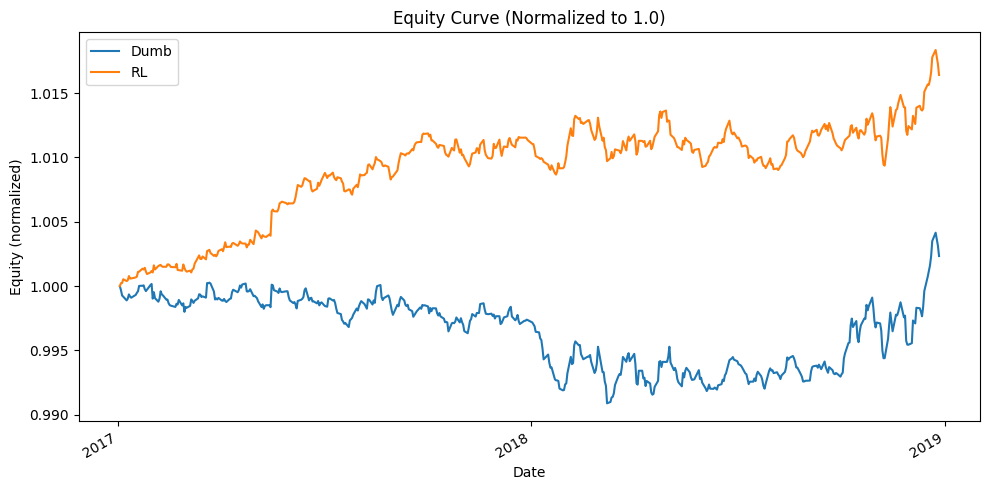

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

bt_dumb_plot = bt_dumb.copy()
bt_rl_plot   = bt_rl.copy()

bt_dumb_plot["Date_naive"] = pd.to_datetime(bt_dumb_plot["Date"]).dt.tz_localize(None)
bt_rl_plot["Date_naive"]   = pd.to_datetime(bt_rl_plot["Date"]).dt.tz_localize(None)

ax.plot(bt_dumb_plot["Date_naive"], bt_dumb_plot["nav"] / bt_dumb_plot["nav"].iloc[0], label="Dumb")
ax.plot(bt_rl_plot["Date_naive"],   bt_rl_plot["nav"]   / bt_rl_plot["nav"].iloc[0],   label="RL")

ax.set_title("Equity Curve (Normalized to 1.0)")
ax.set_xlabel("Date")
ax.set_ylabel("Equity (normalized)")
ax.legend()

ax.tick_params(axis="x", bottom=True, labelbottom=True)
ax.spines["bottom"].set_visible(True)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

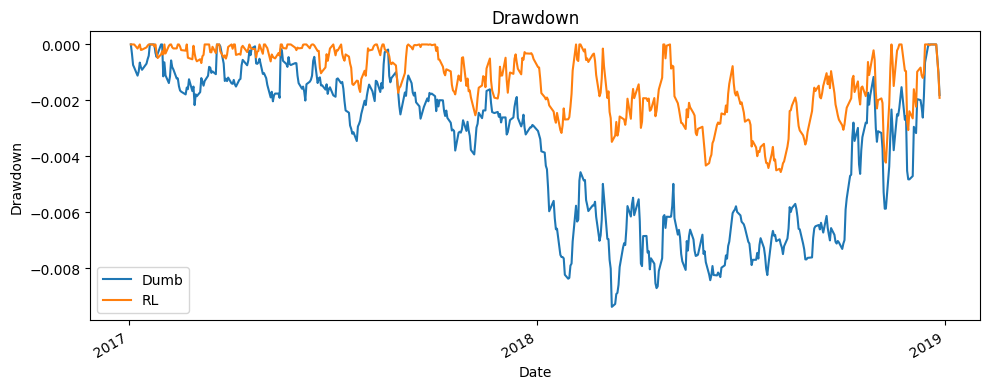

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

bt_dumb_plot = bt_dumb.copy()
bt_rl_plot   = bt_rl.copy()

bt_dumb_plot["Date_naive"] = pd.to_datetime(bt_dumb_plot["Date"]).dt.tz_localize(None)
bt_rl_plot["Date_naive"]   = pd.to_datetime(bt_rl_plot["Date"]).dt.tz_localize(None)

ax.plot(bt_dumb_plot["Date_naive"], _drawdown_curve(bt_dumb["nav"]), label="Dumb")
ax.plot(bt_rl_plot["Date_naive"],   _drawdown_curve(bt_rl["nav"]),   label="RL")

ax.set_title("Drawdown")
ax.set_xlabel("Date")
ax.set_ylabel("Drawdown")
ax.legend()

ax.tick_params(axis="x", bottom=True, labelbottom=True)
ax.spines["bottom"].set_visible(True)

ax.xaxis.set_major_locator(mdates.YearLocator())          
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  
fig.autofmt_xdate()

plt.tight_layout()
plt.show()